In [0]:
#Everything was done on google colab
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1NEW3s3JZZcwH0x7saFxhOTZ5hY1ClCqH'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
winereviews = pd.read_csv('Filename.csv').drop('Unnamed: 0',axis=1)



#winereviews = pd.read_csv('winemag-data-130k-v2.csv').drop('Unnamed: 0',axis=1)

# Visualizations 1 & 2

Text(0.5, 1.0, 'Correlation between Points and Price')

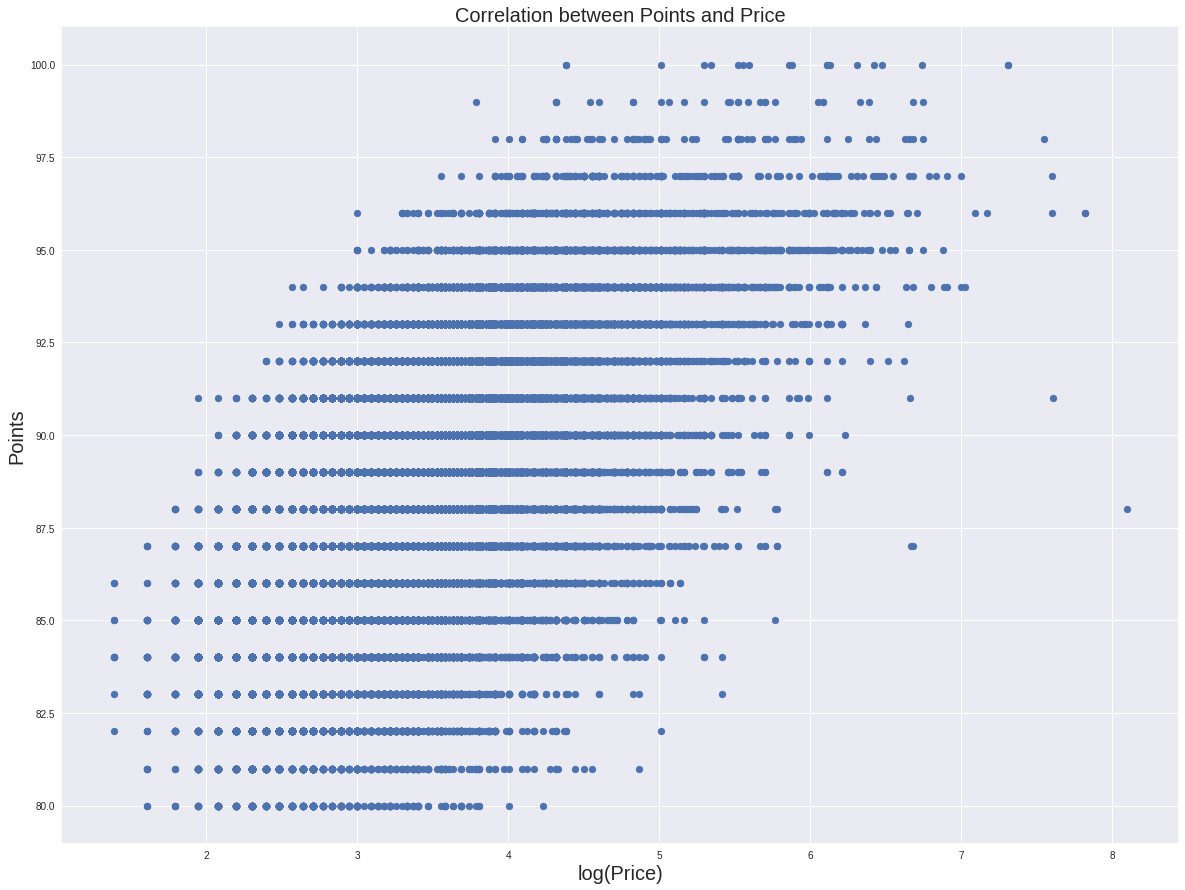

In [0]:
fig = plt.figure(figsize=(20,15))
x = np.log(winereviews.price)
y = winereviews.points
plt.scatter(x,y)
plt.xlabel('log(Price)', fontsize=20)
plt.ylabel('Points', fontsize=20)
plt.title('Correlation between Points and Price',fontsize=20)

There does exist a corelation between the points given to the wine and the logof the price og the wine. A linear combination of the variables can give a straight line but that line does not fit the data. But one trend is that greater the points, greater is the price of wine. To see a relationship between two quantitative variables, I have chosen a scatter plot. The plot uses points as the mark to represent the corelation and position as a channel to represen the trend.

Text(0.5, 1.0, 'Distribution of points in top 10 reviewed wines')

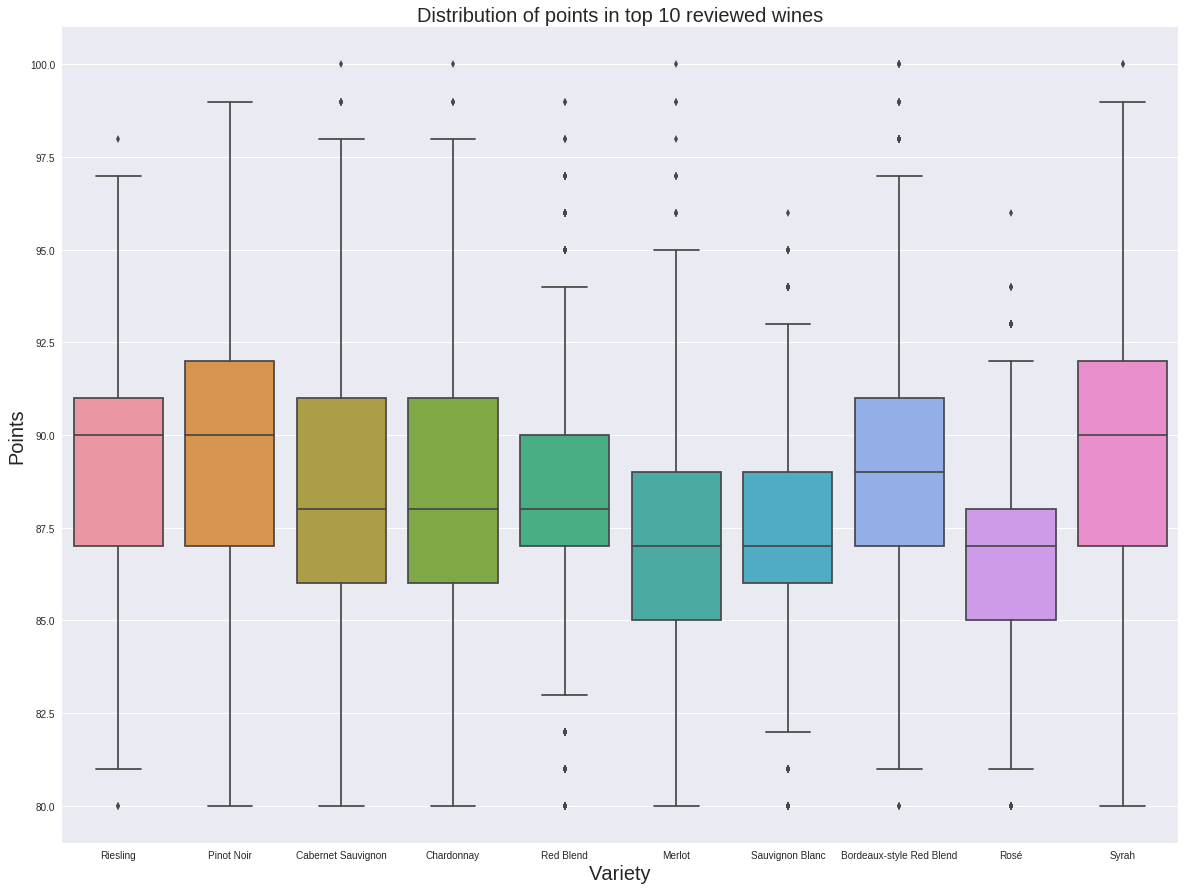

In [0]:
fig = plt.figure(figsize=(20,15))
top_reviewed_wines = winereviews.variety.value_counts().head(10)
points_top_reviewed_wines = winereviews[winereviews.variety.isin(top_reviewed_wines.index)]
x = points_top_reviewed_wines.variety
y = points_top_reviewed_wines.points
sns.boxplot(x,y)
plt.xlabel('Variety', fontsize=20)
plt.ylabel('Points', fontsize=20)
plt.title('Distribution of points in top 10 reviewed wines',fontsize=20)

Text(0.5, 1.0, 'Distribution of points in top 10 listed countries')

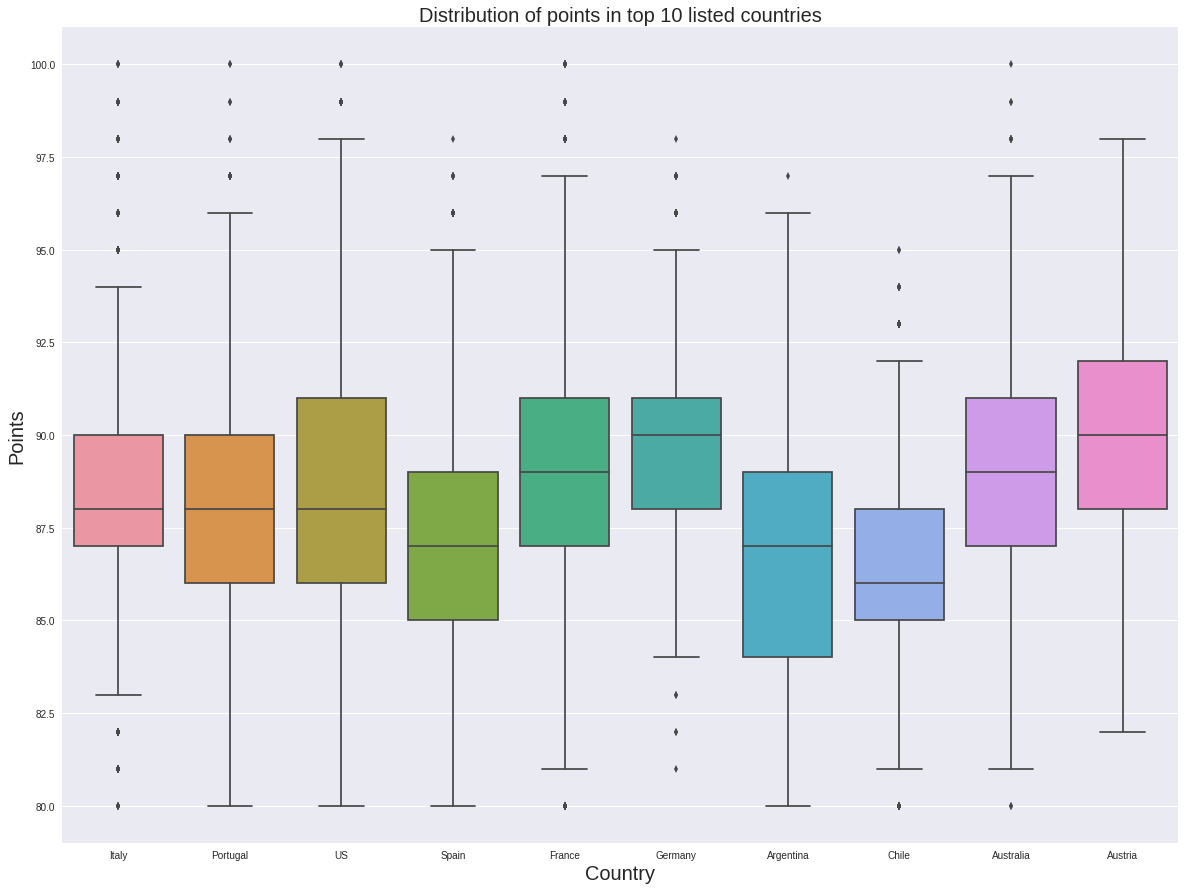

In [0]:
fig = plt.figure(figsize=(20,15))
top_country_wines = winereviews.country.value_counts().head(10)
points_top_country_wines = winereviews[winereviews.country.isin(top_country_wines.index)]
x = points_top_country_wines.country
y = points_top_country_wines.points
sns.boxplot(x,y)
plt.xlabel('Country', fontsize=20)
plt.ylabel('Points', fontsize=20)
plt.title('Distribution of points in top 10 listed countries',fontsize=20)

The plot shows the distribution of points of the top 10 variety of wines that have maximim number of reviews. This plot is basically to compare the top reviewed wines and checking out their range and their medians. I have chosen a box plot to show the distributions of each variety. Boxes and lines are the marks to represent the distributions and position, color and area are the channels to show the points distribution and distinguish between varieties. 

A similar plot is done to show distribution of points of top countries listed in the dataset.

# Data PreProcessing

In [0]:
#FillNA
winereviews_temp = winereviews.fillna(winereviews.median())

#Log transformation has a better corelation with the points
winereviews_temp["price"] = np.log(winereviews_temp["price"])

#From the plots we pick the required features
X_features = winereviews_temp[["country", "price", "variety"]]

#The text feature
X_text = winereviews_temp[["description"]]

#Target variable
y = winereviews_temp[["points"]]

In [0]:
#One hot Encoding of the features
X_features = pd.get_dummies(X_features, sparse=True)

#Vectorizing the text features: Tfidf vectorizer
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(list(X_text["description"]))

X_text.shape

(129971, 31275)

In [0]:
#Get top features using TruncatedSVD as PCA does not take large sparse matrices
from sklearn.decomposition import PCA, TruncatedSVD
truncatedsvd = TruncatedSVD(n_components=100)
truncatedsvd_fit = truncatedsvd.fit(X_text)
X_text = pd.DataFrame(truncatedsvd.transform(X_text))

In [0]:
#Conbine the oneHotEncoded features with text features
X = pd.concat([X_features, X_text], axis=1)
X.shape

(129971, 851)

In [0]:
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [0]:
#Scale the continous variable price 
trainingPriceMedian = X_train["price"].median()
X_train.loc[:,"price"].fillna(trainingPriceMedian, inplace=True)
X_test.loc[:,"price"].fillna(trainingPriceMedian, inplace=True)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train["price"].values.reshape(-1,1))
#X_train["price"] = scaler.fit_transform(X_train["price"].values.reshape(-1,1))
#X_test["price"] = scaler.transform(X_test["price"].values.reshape(-1,1))

# Modelling

In [0]:
#Ridge Regression

from sklearn.linear_model import Ridge
ridge = Ridge()
parameters_ridge = {"alpha" : [1e-3, 1e-2, 1e-1, 1]}
grid_ridge = GridSearchCV(ridge,parameters_ridge, cv=10, scoring="neg_mean_squared_error")
ridge_fit = grid_ridge.fit(X_train, y_train)

ridge_best = ridge_fit.best_estimator_.fit(X_train, y_train)

print("r2 / variance : ", ridge_best.score(X_test, y_test))
print("Mean squared error: %.2f" % mean_squared_error(y_test, ridge_best.predict(X_test)))

r2 / variance :  0.589524693819625
Mean squared error: 3.78


In [0]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#parameters_rf = {"max_depth" : [1], "n_estimators": [10]}
parameters_rf = {"max_depth" : [1, 2, 4, 8, 16, 32, 64], "n_estimators": [10, 20, 30, 40, 80, 100]}
rf = RandomizedSearchCV(RandomForestRegressor(max_features="sqrt", random_state=0, bootstrap=False), parameters_rf, scoring="neg_mean_squared_error", cv=10)
rf_fit = rf.fit(X_train, y_train)

rf_best = rf_fit.best_estimator_.fit(X_train, y_train)

print("r2 / variance : ", rf_best.score(X_test, y_test))
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_best.predict(X_test)))

r2 / variance :  0.5181555471393826
Mean squared error: 4.44


In [14]:
#Lasso Regression
from sklearn.linear_model import Lasso
lass = Lasso()
parameters_lasso = {"alpha" : [1e-3, 1e-2, 1e-1, 1]}
grid_lasso = GridSearchCV(lass,parameters_lasso, cv=10, scoring="neg_mean_squared_error")
lasso_fit = grid_lasso.fit(X_train, y_train)

lasso_best = lasso_fit.best_estimator_.fit(X_train, y_train)

print("r2 / variance : ", lasso_best.score(X_test, y_test))
print("Mean squared error: %.2f" % mean_squared_error(y_test, lasso_best.predict(X_test)))

r2 / variance :  0.5782107133146275
Mean squared error: 3.89


# Visualization 3


In [0]:
ridge_scores = [ridge_fit.cv_results_["split" + str(i) + "_test_score"][3] for i in range(10)]
rf_scores = [rf_fit.cv_results_["split" + str(i) + "_test_score"][6] for i in range(10)]
lasso_scores = [lasso_fit.cv_results_["split" + str(i) + "_test_score"][0] for i in range(10)]

Text(0.5, 1.0, 'Model Performance')

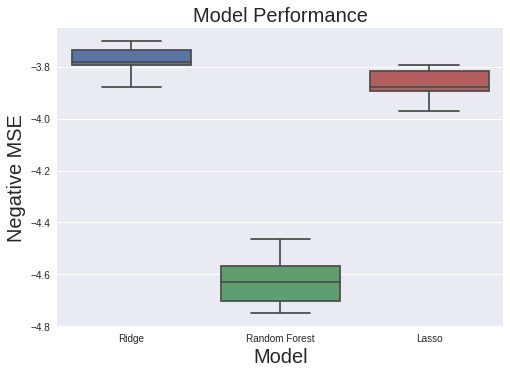

In [26]:
#fig = plt.figure(figsize=(20,15))
x = ['Ridge', "Random Forest", "Lasso"]
y = [ridge_scores, rf_scores, lasso_scores]
sns.boxplot(x,y)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Negative MSE', fontsize=20)
plt.title('Model Performance',fontsize=20)

The above plot is the negative mean squared model for 3 models, that is ridge regression, random forest and Lasso regression. The parameters are chosen based on scores of cv_results for each model and value of 10 fold cv is taken.

The plot uses boxes and lines as the mark and position and area as the channel to show the negative MSE and the distribution respectively. This seemed a good way to see and compare the distributions of results of each of the models. 

In my case ridge regression seemed to have performed the best among the models chosen.

# Visualization 4


Text(0, 0.5, 'Coefficient')

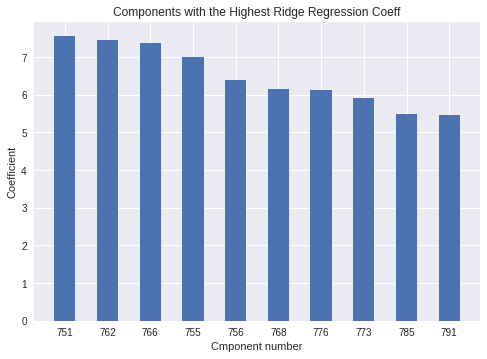

In [27]:
coefs = np.abs(ridge_best.coef_)
indices = coefs[0].argsort()[-10:][::-1]
x = []
y = []
for i in indices:
  x.append(str(i))
  y.append(coefs[0][i])
  
plt.bar(x,y, width = 0.5)
plt.title('Components with the Highest Ridge Regression Coeff')
plt.xlabel("Cmponent number")
plt.ylabel("Coefficient")

This is a bar plot of weights taken from the model. Line is used as a mark and position/length is the channel to represent the coefficients. This is ideal to a catagorical and a quantitative attribute to be encoded.